# Setup

In [26]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
import datetime
import cv2
from keras import backend as K
from keras.layers import Layer,InputSpec
from keras import layers
import keras.layers as kl
from glob import glob
from sklearn.metrics import roc_curve, auc
from keras.preprocessing import image
from tensorflow.keras.models import Sequential
from sklearn.metrics import roc_auc_score
from sklearn import preprocessing
from tensorflow.keras import callbacks 
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from  matplotlib import pyplot as plt
from tensorflow.keras import Model
from tensorflow.keras.layers import concatenate, Dense, Conv2D, MaxPooling2D, Flatten, Input, Activation, add, AveragePooling2D, BatchNormalization, Dropout
%matplotlib inline
import shutil
from sklearn.metrics import  precision_score, recall_score, accuracy_score,classification_report ,confusion_matrix
from tensorflow.python.platform import build_info as tf_build_info
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [27]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Data Preparation

In [28]:
# Environment variable
main_dir = 'D:/Data/HAM100000 - Harvard Dataset'
main_img_dir = main_dir + '/img_data'
preprocessed_data_dir = main_dir + '/preprocessed_data'
train_dir = preprocessed_data_dir + '/train'
test_dir = preprocessed_data_dir + '/val'
train_label = preprocessed_data_dir + '/train_label.csv'
val_label = preprocessed_data_dir + '/val_label.csv'

model_path = 'nasnetmobile_10split_LRStr.hdf5'

In [29]:
target_size = (224, 224)
def Get_data(df_path, img_path, _target_size):
    img_list = []
    labels = []
    ages = []
    sex_list = []
    localizations = []
    
    df = pd.read_csv(df_path)
    for index, row in df.iterrows():
        img_list.append(cv2.imread(img_path + '/' + row['image_id'] + '.jpg'))
        labels.append(row['dx'])
        ages.append(float(row['age']))
        sex_list.append(row['sex'])
        localizations.append(row['localization'])
    for x in range(len(img_list)):
        img_list[x] = tf.keras.preprocessing.image.smart_resize(img_list[x], _target_size)
        img_list[x] = tf.keras.applications.nasnet.preprocess_input(img_list[x])
    le = preprocessing.LabelEncoder()
    le.fit(labels)
    labels = le.transform(labels)
    labels = tf.keras.utils.to_categorical(labels)
    return (img_list, ages, sex_list, localizations), labels

In [30]:
train_df = pd.read_csv(train_label)
train_df.head()

,Unnamed: 0,image_id,dx,age,sex,localization
0,0,ISIC_0027419,bkl,80.0,male,scalp
1,1,ISIC_0025030,bkl,80.0,male,scalp
2,2,ISIC_0026769,bkl,80.0,male,scalp
3,3,ISIC_0025661,bkl,80.0,male,scalp
4,4,ISIC_0031633,bkl,75.0,male,ear


In [31]:
val_df = pd.read_csv(val_label)
val_df.head()

,Unnamed: 0,image_id,dx,age,sex,localization
0,2973,ISIC_0031531,bcc,70.0,male,back
1,483,ISIC_0026526,bkl,60.0,male,face
2,8870,ISIC_0026805,nv,75.0,female,lower extremity
3,1991,ISIC_0030756,mel,85.0,male,chest
4,8324,ISIC_0024834,nv,70.0,male,chest


## Training Data

In [32]:
(train_img_lst, train_ages, train_sexes, train_localizations), labels = Get_data(train_label, main_img_dir, target_size)

In [33]:
any(elem is None for elem in train_img_lst)

False

In [34]:
print("Number of images: {}".format(len(train_img_lst)))
print("Image shape: {0} {1}".format(train_img_lst[0].shape[0], train_img_lst[0].shape[1]))
print("Example of Age: {}".format(train_ages[0]))
print("Example of Sex: {}".format(train_sexes[0]))
print("Example of Localization: {}".format(train_localizations[0]))

Number of images: 8962
Image shape: 224 224
Example of Age: 80.0
Example of Sex: male
Example of Localization: scalp


## Validation Data

In [35]:
(val_img_lst, val_ages, val_sexes, val_localizations), val_labels = Get_data(val_label, main_img_dir, target_size)

In [36]:
any(elem is None for elem in val_img_lst)

False

In [37]:
print("Number of images: {}".format(len(val_img_lst)))
print("Image shape: {0} {1}".format(val_img_lst[0].shape[0], val_img_lst[0].shape[1]))
print("Example of Age: {}".format(val_ages[0]))
print("Example of Sex: {}".format(val_sexes[0]))
print("Example of Localization: {}".format(val_localizations[0]))

Number of images: 996
Image shape: 224 224
Example of Age: 70.0
Example of Sex: male
Example of Localization: back


# Model

## Input Block

In [38]:
age_input = tf.keras.Input(shape=(1,), name='age', dtype=tf.float32)
sex_input = tf.keras.Input(shape=(1,), name='sex', dtype=tf.string)
localizations_input = tf.keras.Input(shape=(1,), name='localization', dtype=tf.string)

inputs = {'age' : age_input,
         'sex' : sex_input,
         'local' : localizations_input}

In [39]:
norm = layers.Normalization()
norm.adapt(np.array(train_df[['age']]))
age_norm_input = norm(age_input)
age_norm_input

<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'normalization_1')>

In [40]:
# Sex input
sex_lookup = layers.StringLookup(vocabulary=np.unique(train_df['sex']))
sex_one_hot = layers.CategoryEncoding(num_tokens=sex_lookup.vocabulary_size())

preprocessed_sex_input = sex_lookup(sex_input)
preprocessed_sex_input = sex_one_hot(preprocessed_sex_input)
preprocessed_sex_input

<KerasTensor: shape=(None, 4) dtype=float32 (created by layer 'category_encoding_2')>

In [41]:
# Localization input
local_lookup = layers.StringLookup(vocabulary=np.unique(train_df['localization']))
local_one_hot = layers.CategoryEncoding(num_tokens=local_lookup.vocabulary_size())

preprocess_local_input = local_lookup(localizations_input)
preprocess_local_input = local_one_hot(preprocess_local_input)
preprocess_local_input

<KerasTensor: shape=(None, 16) dtype=float32 (created by layer 'category_encoding_3')>

In [42]:
preprocessed_inputs = [age_norm_input, preprocessed_sex_input, preprocess_local_input]
preprocessed_inputs_cat = layers.Concatenate()(preprocessed_inputs)

# preprocessed_Model = tf.keras.Model(inputs, preprocessed_inputs_cat)
# tf.keras.utils.plot_model(model = preprocessed_Model , rankdir="LR", dpi=72, show_shapes=True)

preprocessed_inputs_cat

<KerasTensor: shape=(None, 21) dtype=float32 (created by layer 'concatenate_5')>

## Soft Attention

In [43]:
from keras import backend as K
from keras.layers import Layer,InputSpec
import keras.layers as kl
import tensorflow as tf

In [44]:
class SoftAttention(Layer):
    def __init__(self,ch,m,concat_with_x=False,aggregate=False,**kwargs):
        self.channels=int(ch)
        self.multiheads = m
        self.aggregate_channels = aggregate
        self.concat_input_with_scaled = concat_with_x

        
        super(SoftAttention,self).__init__(**kwargs)

    def build(self,input_shape):

        self.i_shape = input_shape

        kernel_shape_conv3d = (self.channels, 3, 3) + (1, self.multiheads) # DHWC
    
        self.out_attention_maps_shape = input_shape[0:1]+(self.multiheads,)+input_shape[1:-1]
        
        if self.aggregate_channels==False:

            self.out_features_shape = input_shape[:-1]+(input_shape[-1]+(input_shape[-1]*self.multiheads),)
        else:
            if self.concat_input_with_scaled:
                self.out_features_shape = input_shape[:-1]+(input_shape[-1]*2,)
            else:
                self.out_features_shape = input_shape
        

        self.kernel_conv3d = self.add_weight(shape=kernel_shape_conv3d,
                                        initializer='he_uniform',
                                        name='kernel_conv3d')
        self.bias_conv3d = self.add_weight(shape=(self.multiheads,),
                                      initializer='zeros',
                                      name='bias_conv3d')

        super(SoftAttention, self).build(input_shape)

    def call(self, x):

        exp_x = K.expand_dims(x,axis=-1)

        c3d = K.conv3d(exp_x,
                     kernel=self.kernel_conv3d,
                     strides=(1,1,self.i_shape[-1]), padding='same', data_format='channels_last')
        conv3d = K.bias_add(c3d,
                        self.bias_conv3d)
        conv3d = kl.Activation('relu')(conv3d)

        conv3d = K.permute_dimensions(conv3d,pattern=(0,4,1,2,3))

        
        conv3d = K.squeeze(conv3d, axis=-1)
        conv3d = K.reshape(conv3d,shape=(-1, self.multiheads ,self.i_shape[1]*self.i_shape[2]))

        softmax_alpha = K.softmax(conv3d, axis=-1) 
        softmax_alpha = kl.Reshape(target_shape=(self.multiheads, self.i_shape[1],self.i_shape[2]))(softmax_alpha)

        
        if self.aggregate_channels==False:
            exp_softmax_alpha = K.expand_dims(softmax_alpha, axis=-1)       
            exp_softmax_alpha = K.permute_dimensions(exp_softmax_alpha,pattern=(0,2,3,1,4))
   
            x_exp = K.expand_dims(x,axis=-2)
   
            u = kl.Multiply()([exp_softmax_alpha, x_exp])   
  
            u = kl.Reshape(target_shape=(self.i_shape[1],self.i_shape[2],u.shape[-1]*u.shape[-2]))(u)

        else:
            exp_softmax_alpha = K.permute_dimensions(softmax_alpha,pattern=(0,2,3,1))

            exp_softmax_alpha = K.sum(exp_softmax_alpha,axis=-1)

            exp_softmax_alpha = K.expand_dims(exp_softmax_alpha, axis=-1)

            u = kl.Multiply()([exp_softmax_alpha, x])   

        if self.concat_input_with_scaled:
            o = kl.Concatenate(axis=-1)([u,x])
        else:
            o = u
        
        return [o, softmax_alpha]

    def compute_output_shape(self, input_shape): 
        return [self.out_features_shape, self.out_attention_maps_shape]

    
    def get_config(self):
        return super(SoftAttention,self).get_config()

## Base Model

In [45]:
NASNetMobile = tf.keras.applications.NASNetMobile(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,

)

inputs['image'] = NASNetMobile.input

# Exclude the last 28 layers of the model.
NASNetMobile_output = NASNetMobile.layers[-23].output

## Final Model

In [46]:
attention_layer,map2 = SoftAttention(aggregate=True,m=16,concat_with_x=False,ch=int(NASNetMobile_output.shape[-1]),name='soft_attention')(NASNetMobile_output)
attention_layer=(MaxPooling2D(pool_size=(2, 2),padding="same")(attention_layer))
NASNetMobile_output=(MaxPooling2D(pool_size=(2, 2),padding="same")(NASNetMobile_output))

NASNetMobile_output = layers.Concatenate()([NASNetMobile_output, attention_layer])
NASNetMobile_output = Activation('relu')(NASNetMobile_output)
NASNetMobile_output = Dropout(0.5)(NASNetMobile_output)

In [47]:
output = Flatten()(NASNetMobile_output)
preprocessed_inputs_cat = (layers.Dense(4096, activation = 'relu')(preprocessed_inputs_cat))
output = layers.Concatenate()([output, preprocessed_inputs_cat])
output = Dense(7, activation='softmax')(output)
model = Model(inputs=inputs, outputs=output)

In [48]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 stem_conv1 (Conv2D)            (None, 111, 111, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 stem_bn1 (BatchNormalization)  (None, 111, 111, 32  128         ['stem_conv1[0][0]']             
                                )                                                             

                                                                                                  
 separable_conv_1_pad_reduction  (None, 115, 115, 32  0          ['activation_195[0][0]']         
 _right3_stem_1 (ZeroPadding2D)  )                                                                
                                                                                                  
 activation_197 (Activation)    (None, 56, 56, 11)   0           ['reduction_add_1_stem_1[0][0]'] 
                                                                                                  
 separable_conv_1_bn_reduction_  (None, 56, 56, 11)  44          ['separable_conv_1_reduction_righ
 right2_stem_1 (BatchNormalizat                                  t2_stem_1[0][0]']                
 ion)                                                                                             
                                                                                                  
 separable

 add_4 (Add)                    (None, 56, 56, 11)   0           ['reduction_add_2_stem_1[0][0]', 
                                                                  'reduction_left4_stem_1[0][0]'] 
                                                                                                  
 reduction_add4_stem_1 (Add)    (None, 56, 56, 11)   0           ['separable_conv_2_bn_reduction_l
                                                                 eft4_stem_1[0][0]',              
                                                                  'reduction_right5_stem_1[0][0]']
                                                                                                  
 cropping2d_4 (Cropping2D)      (None, 111, 111, 32  0           ['zero_padding2d_4[0][0]']       
                                )                                                                 
                                                                                                  
 reduction

 separable_conv_2_bn_reduction_  (None, 28, 28, 22)  88          ['separable_conv_2_reduction_righ
 right1_stem_2 (BatchNormalizat                                  t1_stem_2[0][0]']                
 ion)                                                                                             
                                                                                                  
 separable_conv_1_pad_reduction  (None, 61, 61, 22)  0           ['activation_204[0][0]']         
 _right2_stem_2 (ZeroPadding2D)                                                                   
                                                                                                  
 activation_206 (Activation)    (None, 56, 56, 22)   0           ['adjust_bn_stem_2[0][0]']       
                                                                                                  
 reduction_add_1_stem_2 (Add)   (None, 28, 28, 22)   0           ['separable_conv_2_bn_reduction_l
          

                                                                                                  
 separable_conv_2_bn_reduction_  (None, 28, 28, 22)  88          ['separable_conv_2_reduction_left
 left4_stem_2 (BatchNormalizati                                  4_stem_2[0][0]']                 
 on)                                                                                              
                                                                                                  
 reduction_right5_stem_2 (MaxPo  (None, 28, 28, 22)  0           ['reduction_pad_1_stem_2[0][0]'] 
 oling2D)                                                                                         
                                                                                                  
 zero_padding2d_5 (ZeroPadding2  (None, 57, 57, 44)  0           ['adjust_relu_1_0[0][0]']        
 D)                                                                                               
          

 separable_conv_1_bn_normal_lef  (None, 28, 28, 44)  176         ['separable_conv_1_normal_left2_0
 t2_0 (BatchNormalization)                                       [0][0]']                         
                                                                                                  
 separable_conv_1_bn_normal_rig  (None, 28, 28, 44)  176         ['separable_conv_1_normal_right2_
 ht2_0 (BatchNormalization)                                      0[0][0]']                        
                                                                                                  
 separable_conv_1_bn_normal_lef  (None, 28, 28, 44)  176         ['separable_conv_1_normal_left5_0
 t5_0 (BatchNormalization)                                       [0][0]']                         
                                                                                                  
 activation_212 (Activation)    (None, 28, 28, 44)   0           ['separable_conv_1_bn_normal_left
          

 normal_concat_0 (Concatenate)  (None, 28, 28, 264)  0           ['adjust_bn_0[0][0]',            
                                                                  'normal_add_1_0[0][0]',         
                                                                  'normal_add_2_0[0][0]',         
                                                                  'normal_add_3_0[0][0]',         
                                                                  'normal_add_4_0[0][0]',         
                                                                  'normal_add_5_0[0][0]']         
                                                                                                  
 activation_221 (Activation)    (None, 28, 28, 88)   0           ['reduction_concat_stem_2[0][0]']
                                                                                                  
 activation_222 (Activation)    (None, 28, 28, 264)  0           ['normal_concat_0[0][0]']        
          

 separable_conv_2_normal_left2_  (None, 28, 28, 44)  3036        ['activation_228[0][0]']         
 1 (SeparableConv2D)                                                                              
                                                                                                  
 separable_conv_2_normal_right2  (None, 28, 28, 44)  2332        ['activation_230[0][0]']         
 _1 (SeparableConv2D)                                                                             
                                                                                                  
 separable_conv_2_normal_left5_  (None, 28, 28, 44)  2332        ['activation_232[0][0]']         
 1 (SeparableConv2D)                                                                              
                                                                                                  
 separable_conv_2_bn_normal_lef  (None, 28, 28, 44)  176         ['separable_conv_2_normal_left1_1
 t1_1 (Bat

 activation_243 (Activation)    (None, 28, 28, 44)   0           ['normal_bn_1_2[0][0]']          
                                                                                                  
 separable_conv_1_normal_left1_  (None, 28, 28, 44)  3036        ['activation_235[0][0]']         
 2 (SeparableConv2D)                                                                              
                                                                                                  
 separable_conv_1_normal_right1  (None, 28, 28, 44)  2332        ['activation_237[0][0]']         
 _2 (SeparableConv2D)                                                                             
                                                                                                  
 separable_conv_1_normal_left2_  (None, 28, 28, 44)  3036        ['activation_239[0][0]']         
 2 (SeparableConv2D)                                                                              
          

 separable_conv_2_bn_normal_lef  (None, 28, 28, 44)  176         ['separable_conv_2_normal_left5_2
 t5_2 (BatchNormalization)                                       [0][0]']                         
                                                                                                  
 normal_add_1_2 (Add)           (None, 28, 28, 44)   0           ['separable_conv_2_bn_normal_left
                                                                 1_2[0][0]',                      
                                                                  'separable_conv_2_bn_normal_righ
                                                                 t1_2[0][0]']                     
                                                                                                  
 normal_add_2_2 (Add)           (None, 28, 28, 44)   0           ['separable_conv_2_bn_normal_left
                                                                 2_2[0][0]',                      
          

 t5_3 (BatchNormalization)                                       [0][0]']                         
                                                                                                  
 activation_248 (Activation)    (None, 28, 28, 44)   0           ['separable_conv_1_bn_normal_left
                                                                 1_3[0][0]']                      
                                                                                                  
 activation_250 (Activation)    (None, 28, 28, 44)   0           ['separable_conv_1_bn_normal_righ
                                                                 t1_3[0][0]']                     
                                                                                                  
 activation_252 (Activation)    (None, 28, 28, 44)   0           ['separable_conv_1_bn_normal_left
                                                                 2_3[0][0]']                      
          

 activation_258 (Activation)    (None, 28, 28, 264)  0           ['normal_concat_3[0][0]']        
                                                                                                  
 activation_257 (Activation)    (None, 28, 28, 264)  0           ['normal_concat_2[0][0]']        
                                                                                                  
 reduction_conv_1_reduce_4 (Con  (None, 28, 28, 88)  23232       ['activation_258[0][0]']         
 v2D)                                                                                             
                                                                                                  
 adjust_conv_projection_reduce_  (None, 28, 28, 88)  23232       ['activation_257[0][0]']         
 4 (Conv2D)                                                                                       
                                                                                                  
 reduction

                                                                 ]                                
                                                                                                  
 separable_conv_1_bn_reduction_  (None, 14, 14, 88)  352         ['separable_conv_1_reduction_righ
 right2_reduce_4 (BatchNormaliz                                  t2_reduce_4[0][0]']              
 ation)                                                                                           
                                                                                                  
 separable_conv_1_reduction_rig  (None, 14, 14, 88)  9944        ['separable_conv_1_pad_reduction_
 ht3_reduce_4 (SeparableConv2D)                                  right3_reduce_4[0][0]']          
                                                                                                  
 separable_conv_1_reduction_lef  (None, 14, 14, 88)  8536        ['activation_267[0][0]']         
 t4_reduce

                                                                 eft4_reduce_4[0][0]',            
                                                                  'reduction_right5_reduce_4[0][0]
                                                                 ']                               
                                                                                                  
 cropping2d_6 (Cropping2D)      (None, 28, 28, 264)  0           ['zero_padding2d_6[0][0]']       
                                                                                                  
 reduction_concat_reduce_4 (Con  (None, 14, 14, 352)  0          ['reduction_add_2_reduce_4[0][0]'
 catenate)                                                       , 'reduction_add3_reduce_4[0][0]'
                                                                 , 'add_6[0][0]',                 
                                                                  'reduction_add4_reduce_4[0][0]']
          

                                                                                                  
 activation_277 (Activation)    (None, 14, 14, 88)   0           ['separable_conv_1_bn_normal_righ
                                                                 t2_5[0][0]']                     
                                                                                                  
 activation_279 (Activation)    (None, 14, 14, 88)   0           ['separable_conv_1_bn_normal_left
                                                                 5_5[0][0]']                      
                                                                                                  
 separable_conv_2_normal_left1_  (None, 14, 14, 88)  9944        ['activation_271[0][0]']         
 5 (SeparableConv2D)                                                                              
                                                                                                  
 separable

 adjust_bn_6 (BatchNormalizatio  (None, 14, 14, 88)  352         ['adjust_conv_projection_6[0][0]'
 n)                                                              ]                                
                                                                                                  
 normal_bn_1_6 (BatchNormalizat  (None, 14, 14, 88)  352         ['normal_conv_1_6[0][0]']        
 ion)                                                                                             
                                                                                                  
 activation_282 (Activation)    (None, 14, 14, 88)   0           ['normal_bn_1_6[0][0]']          
                                                                                                  
 activation_284 (Activation)    (None, 14, 14, 88)   0           ['adjust_bn_6[0][0]']            
                                                                                                  
 activatio

 t2_6 (BatchNormalization)                                       [0][0]']                         
                                                                                                  
 separable_conv_2_bn_normal_rig  (None, 14, 14, 88)  352         ['separable_conv_2_normal_right2_
 ht2_6 (BatchNormalization)                                      6[0][0]']                        
                                                                                                  
 normal_left3_6 (AveragePooling  (None, 14, 14, 88)  0           ['normal_bn_1_6[0][0]']          
 2D)                                                                                              
                                                                                                  
 normal_left4_6 (AveragePooling  (None, 14, 14, 88)  0           ['adjust_bn_6[0][0]']            
 2D)                                                                                              
          

                                                                                                  
 separable_conv_1_bn_normal_lef  (None, 14, 14, 88)  352         ['separable_conv_1_normal_left1_7
 t1_7 (BatchNormalization)                                       [0][0]']                         
                                                                                                  
 separable_conv_1_bn_normal_rig  (None, 14, 14, 88)  352         ['separable_conv_1_normal_right1_
 ht1_7 (BatchNormalization)                                      7[0][0]']                        
                                                                                                  
 separable_conv_1_bn_normal_lef  (None, 14, 14, 88)  352         ['separable_conv_1_normal_left2_7
 t2_7 (BatchNormalization)                                       [0][0]']                         
                                                                                                  
 separable

 normal_add_4_7 (Add)           (None, 14, 14, 88)   0           ['normal_left4_7[0][0]',         
                                                                  'normal_right4_7[0][0]']        
                                                                                                  
 normal_add_5_7 (Add)           (None, 14, 14, 88)   0           ['separable_conv_2_bn_normal_left
                                                                 5_7[0][0]',                      
                                                                  'normal_bn_1_7[0][0]']          
                                                                                                  
 normal_concat_7 (Concatenate)  (None, 14, 14, 528)  0           ['adjust_bn_7[0][0]',            
                                                                  'normal_add_1_7[0][0]',         
                                                                  'normal_add_2_7[0][0]',         
          

                                                                                                  
 separable_conv_2_normal_left1_  (None, 14, 14, 88)  9944        ['activation_307[0][0]']         
 8 (SeparableConv2D)                                                                              
                                                                                                  
 separable_conv_2_normal_right1  (None, 14, 14, 88)  8536        ['activation_309[0][0]']         
 _8 (SeparableConv2D)                                                                             
                                                                                                  
 separable_conv_2_normal_left2_  (None, 14, 14, 88)  9944        ['activation_311[0][0]']         
 8 (SeparableConv2D)                                                                              
                                                                                                  
 separable

 activation_318 (Activation)    (None, 14, 14, 176)  0           ['reduction_bn_1_reduce_8[0][0]']
                                                                                                  
 activation_320 (Activation)    (None, 14, 14, 176)  0           ['adjust_bn_reduce_8[0][0]']     
                                                                                                  
 separable_conv_1_pad_reduction  (None, 17, 17, 176)  0          ['activation_318[0][0]']         
 _left1_reduce_8 (ZeroPadding2D                                                                   
 )                                                                                                
                                                                                                  
 separable_conv_1_pad_reduction  (None, 19, 19, 176)  0          ['activation_320[0][0]']         
 _right1_reduce_8 (ZeroPadding2                                                                   
 D)       

 right3_reduce_8 (BatchNormaliz                                  t3_reduce_8[0][0]']              
 ation)                                                                                           
                                                                                                  
 separable_conv_1_bn_reduction_  (None, 7, 7, 176)   704         ['separable_conv_1_reduction_left
 left4_reduce_8 (BatchNormaliza                                  4_reduce_8[0][0]']               
 tion)                                                                                            
                                                                                                  
 reduction_pad_1_reduce_8 (Zero  (None, 15, 15, 176)  0          ['reduction_bn_1_reduce_8[0][0]']
 Padding2D)                                                                                       
                                                                                                  
 separable

                                                                                                  
 adjust_conv_1_9 (Conv2D)       (None, 7, 7, 88)     46464       ['adjust_avg_pool_1_9[0][0]']    
                                                                                                  
 adjust_conv_2_9 (Conv2D)       (None, 7, 7, 88)     46464       ['adjust_avg_pool_2_9[0][0]']    
                                                                                                  
 activation_328 (Activation)    (None, 7, 7, 704)    0           ['reduction_concat_reduce_8[0][0]
                                                                 ']                               
                                                                                                  
 concatenate_9 (Concatenate)    (None, 7, 7, 176)    0           ['adjust_conv_1_9[0][0]',        
                                                                  'adjust_conv_2_9[0][0]']        
          

 separable_conv_2_normal_right2  (None, 7, 7, 176)   32560       ['activation_336[0][0]']         
 _9 (SeparableConv2D)                                                                             
                                                                                                  
 separable_conv_2_normal_left5_  (None, 7, 7, 176)   32560       ['activation_338[0][0]']         
 9 (SeparableConv2D)                                                                              
                                                                                                  
 separable_conv_2_bn_normal_lef  (None, 7, 7, 176)   704         ['separable_conv_2_normal_left1_9
 t1_9 (BatchNormalization)                                       [0][0]']                         
                                                                                                  
 separable_conv_2_bn_normal_rig  (None, 7, 7, 176)   704         ['separable_conv_2_normal_right1_
 ht1_9 (Ba

 separable_conv_1_normal_left1_  (None, 7, 7, 176)   35376       ['activation_341[0][0]']         
 10 (SeparableConv2D)                                                                             
                                                                                                  
 separable_conv_1_normal_right1  (None, 7, 7, 176)   32560       ['activation_343[0][0]']         
 _10 (SeparableConv2D)                                                                            
                                                                                                  
 separable_conv_1_normal_left2_  (None, 7, 7, 176)   35376       ['activation_345[0][0]']         
 10 (SeparableConv2D)                                                                             
                                                                                                  
 separable_conv_1_normal_right2  (None, 7, 7, 176)   32560       ['activation_347[0][0]']         
 _10 (Sepa

                                                                                                  
 normal_add_1_10 (Add)          (None, 7, 7, 176)    0           ['separable_conv_2_bn_normal_left
                                                                 1_10[0][0]',                     
                                                                  'separable_conv_2_bn_normal_righ
                                                                 t1_10[0][0]']                    
                                                                                                  
 normal_add_2_10 (Add)          (None, 7, 7, 176)    0           ['separable_conv_2_bn_normal_left
                                                                 2_10[0][0]',                     
                                                                  'separable_conv_2_bn_normal_righ
                                                                 t2_10[0][0]']                    
          

 activation_354 (Activation)    (None, 7, 7, 176)    0           ['separable_conv_1_bn_normal_left
                                                                 1_11[0][0]']                     
                                                                                                  
 activation_356 (Activation)    (None, 7, 7, 176)    0           ['separable_conv_1_bn_normal_righ
                                                                 t1_11[0][0]']                    
                                                                                                  
 activation_358 (Activation)    (None, 7, 7, 176)    0           ['separable_conv_1_bn_normal_left
                                                                 2_11[0][0]']                     
                                                                                                  
 activation_360 (Activation)    (None, 7, 7, 176)    0           ['separable_conv_1_bn_normal_righ
          

 normal_conv_1_12 (Conv2D)      (None, 7, 7, 176)    185856      ['activation_364[0][0]']         
                                                                                                  
 normal_bn_1_12 (BatchNormaliza  (None, 7, 7, 176)   704         ['normal_conv_1_12[0][0]']       
 tion)                                                                                            
                                                                                                  
 activation_373 (Activation)    (None, 7, 7, 176)    0           ['normal_bn_1_12[0][0]']         
                                                                                                  
 separable_conv_1_normal_left5_  (None, 7, 7, 176)   32560       ['activation_373[0][0]']         
 12 (SeparableConv2D)                                                                             
                                                                                                  
 separable

## Training

In [49]:
feature_dict = {'age' : np.array(train_ages),
                'sex' : np.array(train_sexes),
                'local' : np.array(train_localizations),
                'image' : np.array(train_img_lst)}

In [50]:
val_dict = {'age' : np.array(val_ages),
                'sex' : np.array(val_sexes),
                'local' : np.array(val_localizations),
                'image' : np.array(val_img_lst)}

In [51]:
class_weights = { 
                    0: 4.37,  # akiec
                    1: 2.78,  # bcc
                    2: 1.3,  # bkl
                    3: 12.44,  # df
                    4: 1.28,  # mel
                    5: 0.21,  # nv
                    6: 10,  # vasc
                }


checkpoint=  ModelCheckpoint(filepath = model_path,monitor='val_accuracy',save_best_only=True,save_weights_only=True)

In [52]:
opt1=tf.keras.optimizers.Adam(learning_rate=0.001,epsilon=0.1)
model.compile(optimizer=opt1,
             loss='categorical_crossentropy',
             metrics=['accuracy'])

In [53]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              verbose = 1, mode = 'min',
                              patience=5, min_lr=0.0000001)

In [54]:
batch_size = 32 

Earlystop = EarlyStopping(monitor='val_loss', mode='min',patience=35, min_delta=0.001)

with tf.device('/GPU:0'):
    history = model.fit(feature_dict, labels,
                        steps_per_epoch=(len(train_df)/10),
                        epochs=500,
                        validation_data=(val_dict, val_labels), 
                        validation_steps=len(val_df)/batch_size,
                        callbacks=[checkpoint, Earlystop, reduce_lr],
                        class_weight=class_weights)

Epoch 1/500
896/896 [==============================] - 1415s 1s/step - loss: 1.6279 - accuracy: 0.3767 - val_loss: 1.3012 - val_accuracy: 0.6175 - lr: 0.0010
Epoch 2/500
896/896 [==============================] - 1279s 1s/step - loss: 1.1520 - accuracy: 0.5310 - val_loss: 1.1730 - val_accuracy: 0.6114 - lr: 0.0010
Epoch 3/500
896/896 [==============================] - 1286s 1s/step - loss: 0.9030 - accuracy: 0.6239 - val_loss: 0.8128 - val_accuracy: 0.7038 - lr: 0.0010
Epoch 4/500
896/896 [==============================] - 1092s 1s/step - loss: 0.7401 - accuracy: 0.6661 - val_loss: 20.6220 - val_accuracy: 0.6215 - lr: 0.0010
Epoch 5/500
896/896 [==============================] - 1031s 1s/step - loss: 0.7495 - accuracy: 0.6702 - val_loss: 3.1200 - val_accuracy: 0.5914 - lr: 0.0010
Epoch 6/500
896/896 [==============================] - 1032s 1s/step - loss: 0.5695 - accuracy: 0.7126 - val_loss: 1.0055 - val_accuracy: 0.6677 - lr: 0.0010
Epoch 7/500
896/896 [==============================

Epoch 47/500
897/896 [==============================] - ETA: 0s - loss: 0.0200 - accuracy: 0.9797
Epoch 47: ReduceLROnPlateau reducing learning rate to 1e-07.
896/896 [==============================] - 1098s 1s/step - loss: 0.0200 - accuracy: 0.9797 - val_loss: 0.5773 - val_accuracy: 0.8504 - lr: 3.2000e-07
Epoch 48/500
896/896 [==============================] - 1006s 1s/step - loss: 0.0168 - accuracy: 0.9823 - val_loss: 0.5772 - val_accuracy: 0.8494 - lr: 1.0000e-07
Epoch 49/500
896/896 [==============================] - 928s 1s/step - loss: 0.0212 - accuracy: 0.9807 - val_loss: 0.5775 - val_accuracy: 0.8494 - lr: 1.0000e-07
Epoch 50/500
896/896 [==============================] - 917s 1s/step - loss: 0.0203 - accuracy: 0.9790 - val_loss: 0.5775 - val_accuracy: 0.8504 - lr: 1.0000e-07
Epoch 51/500
896/896 [==============================] - 930s 1s/step - loss: 0.0187 - accuracy: 0.9790 - val_loss: 0.5773 - val_accuracy: 0.8504 - lr: 1.0000e-07
Epoch 52/500
896/896 [====================

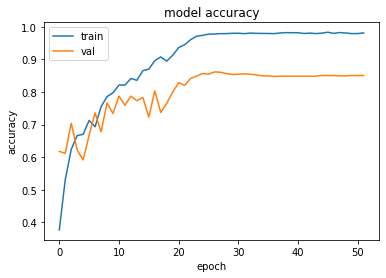

In [55]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

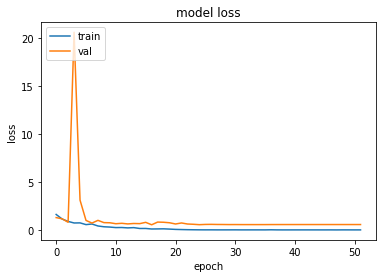

In [56]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [57]:
from tensorflow.keras import models
model.load_weights(model_path)

In [58]:
batch_size = 32 
predictions = model.predict(val_dict, steps=len(val_df)/batch_size, verbose=0)

# Classification report

In [59]:
#geting predictions on test dataset
y_pred = np.argmax(predictions, axis=1)
targetnames = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
#getting the true labels per image 
y_true = np.argmax(val_labels, axis=1)
#getting the predicted labels per image 
y_prob=predictions
from tensorflow.keras.utils import to_categorical
y_test = to_categorical(y_true)

# Creating classification report 
report = classification_report(y_true, y_pred, target_names=targetnames)

print("\nClassification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

       akiec       0.71      0.82      0.76        33
         bcc       0.76      0.73      0.74        51
         bkl       0.73      0.83      0.78       109
          df       0.61      0.92      0.73        12
         mel       0.77      0.53      0.63       111
          nv       0.93      0.93      0.93       666
        vasc       0.65      0.93      0.76        14

    accuracy                           0.86       996
   macro avg       0.74      0.81      0.76       996
weighted avg       0.86      0.86      0.86       996



# Confusion Matrix Metrics

In [60]:
from sklearn.metrics import multilabel_confusion_matrix
multi_cm = multilabel_confusion_matrix(y_true, y_pred)
#print(multi_cm)

# TN     FP
# FN     TP

In [61]:
def cm_compute(_cm, _index, _name):
    print("Confusion Matrix of {}".format(_name))
    print(_cm[index])
    TP = _cm[index][1][1]
    FP = _cm[index][0][1]
    FN = _cm[index][1][0]
    TN = _cm[index][0][0]
    print("True Positive of {0}: {1}".format(_name, TP))
    print("False Positive of {0}: {1}".format(_name, FP))
    print("False Negative of {0}: {1}".format(_name, FN))
    print("True Negative of {0}: {1}".format(_name, TN))
    sensitivity = TP/(TP + FN)
    specificity = TN/(TN + FP)
    print("Sensitivity of {0}: {1}".format(_name, sensitivity))
    print("Specificity of {0}: {1}".format(_name, specificity))
    print("Precision of {0}: {1}".format(_name, TP/(TP + FP)))
    print("Accuracy of {0}: {1}".format(_name, (TP+TN)/(TP + FP + FN + TN)))
    print("Balanced Accuracy of {0} : {1}".format(_name, (sensitivity + specificity)/2))
    print("F1 Score of {0}: {1}".format(_name, (2*TP)/(2*TP + FP + FN)))

### akiec       

In [62]:
index = 0
cm_compute(multi_cm, index, targetnames[index])

Confusion Matrix of akiec
[[952  11]
 [  6  27]]
True Positive of akiec: 27
False Positive of akiec: 11
False Negative of akiec: 6
True Negative of akiec: 952
Sensitivity of akiec: 0.8181818181818182
Specificity of akiec: 0.9885773624091381
Precision of akiec: 0.7105263157894737
Accuracy of akiec: 0.9829317269076305
Balanced Accuracy of akiec : 0.9033795902954782
F1 Score of akiec: 0.7605633802816901


### bcc       

In [63]:
index = 1
cm_compute(multi_cm, index, targetnames[index])

Confusion Matrix of bcc
[[933  12]
 [ 14  37]]
True Positive of bcc: 37
False Positive of bcc: 12
False Negative of bcc: 14
True Negative of bcc: 933
Sensitivity of bcc: 0.7254901960784313
Specificity of bcc: 0.9873015873015873
Precision of bcc: 0.7551020408163265
Accuracy of bcc: 0.9738955823293173
Balanced Accuracy of bcc : 0.8563958916900094
F1 Score of bcc: 0.74


### bkl

In [64]:
index = 2
cm_compute(multi_cm, index, targetnames[index])

Confusion Matrix of bkl
[[853  34]
 [ 18  91]]
True Positive of bkl: 91
False Positive of bkl: 34
False Negative of bkl: 18
True Negative of bkl: 853
Sensitivity of bkl: 0.8348623853211009
Specificity of bkl: 0.9616685456595265
Precision of bkl: 0.728
Accuracy of bkl: 0.9477911646586346
Balanced Accuracy of bkl : 0.8982654654903137
F1 Score of bkl: 0.7777777777777778


### df 

In [65]:
index = 3
cm_compute(multi_cm, index, targetnames[index])

Confusion Matrix of df
[[977   7]
 [  1  11]]
True Positive of df: 11
False Positive of df: 7
False Negative of df: 1
True Negative of df: 977
Sensitivity of df: 0.9166666666666666
Specificity of df: 0.9928861788617886
Precision of df: 0.6111111111111112
Accuracy of df: 0.9919678714859438
Balanced Accuracy of df : 0.9547764227642277
F1 Score of df: 0.7333333333333333


### mel

In [66]:
index = 4
cm_compute(multi_cm, index, targetnames[index])

Confusion Matrix of mel
[[867  18]
 [ 52  59]]
True Positive of mel: 59
False Positive of mel: 18
False Negative of mel: 52
True Negative of mel: 867
Sensitivity of mel: 0.5315315315315315
Specificity of mel: 0.9796610169491525
Precision of mel: 0.7662337662337663
Accuracy of mel: 0.929718875502008
Balanced Accuracy of mel : 0.755596274240342
F1 Score of mel: 0.6276595744680851


### nv

In [67]:
index = 5
cm_compute(multi_cm, index, targetnames[index])

Confusion Matrix of nv
[[281  49]
 [ 46 620]]
True Positive of nv: 620
False Positive of nv: 49
False Negative of nv: 46
True Negative of nv: 281
Sensitivity of nv: 0.9309309309309309
Specificity of nv: 0.8515151515151516
Precision of nv: 0.9267563527653214
Accuracy of nv: 0.9046184738955824
Balanced Accuracy of nv : 0.8912230412230413
F1 Score of nv: 0.9288389513108615


### vasc

In [68]:
index = 6
cm_compute(multi_cm, index, targetnames[index])

Confusion Matrix of vasc
[[975   7]
 [  1  13]]
True Positive of vasc: 13
False Positive of vasc: 7
False Negative of vasc: 1
True Negative of vasc: 975
Sensitivity of vasc: 0.9285714285714286
Specificity of vasc: 0.9928716904276986
Precision of vasc: 0.65
Accuracy of vasc: 0.9919678714859438
Balanced Accuracy of vasc : 0.9607215594995636
F1 Score of vasc: 0.7647058823529411


## Weighted, Macro, Micro, ROC AUC

In [69]:
print("Precision: "+ str(precision_score(y_true, y_pred, average='weighted')))
print("Recall: "+ str(recall_score(y_true, y_pred, average='weighted')))
print("Accuracy: " + str(accuracy_score(y_true, y_pred)))
print("weighted Roc score: " + str(roc_auc_score(y_test,y_prob,multi_class='ovr',average='weighted')))

Precision: 0.8634684586643281
Recall: 0.8614457831325302
Accuracy: 0.8614457831325302
weighted Roc score: 0.9583624097421496


In [70]:
print("Precision: "+ str(precision_score(y_true, y_pred, average='macro')))
print("Recall: "+ str(recall_score(y_true, y_pred, average='macro')))
print("Accuracy: " + str(accuracy_score(y_true, y_pred)))
print("Macro Roc score: " + str(roc_auc_score(y_test,y_prob,multi_class='ovr',average='macro')))

Precision: 0.7353899409594284
Recall: 0.8123192796117011
Accuracy: 0.8614457831325302
Macro Roc score: 0.9714988917607179


In [71]:
print("Precision: "+ str(precision_score(y_true, y_pred, average='micro')))
print("Recall: "+ str(recall_score(y_true, y_pred, average='micro')))
print("Accuracy: " + str(accuracy_score(y_true, y_pred)))
tpr={}
fpr={}
roc_auc={}
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_prob.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
print("Micro Roc score: " + str(roc_auc["micro"]))

Precision: 0.8614457831325302
Recall: 0.8614457831325302
Accuracy: 0.8614457831325302
Micro Roc score: 0.9833218415832002


In [72]:
fpr = {}
tpr = {}
roc_auc = {}
for i in range(7):
    r = roc_auc_score(y_test[:, i], y_prob[:, i])
    print("The ROC AUC score of "+targetnames[i]+" is: "+str(r))

The ROC AUC score of akiec is: 0.9843922086912741
The ROC AUC score of bcc is: 0.9852474323062559
The ROC AUC score of bkl is: 0.9702015866284663
The ROC AUC score of df is: 0.998390921409214
The ROC AUC score of mel is: 0.9022038988140683
The ROC AUC score of nv is: 0.9608563108563108
The ROC AUC score of vasc is: 0.9991998836194356


In [73]:
# Compute ROC curve and ROC area for each class
fpr = {}
tpr = {}
roc_auc = dict()
for i in range(7):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_prob[:, i], drop_intermediate=False)
    roc_auc[i] = auc(fpr[i], tpr[i])

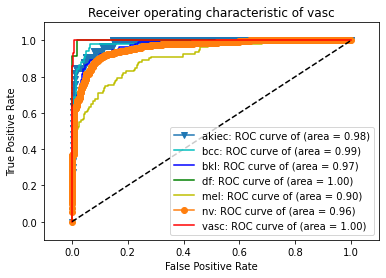

In [74]:
plt.plot(fpr[0], tpr[0],'v-',label='akiec: ROC curve of (area = %0.2f)' % roc_auc[0])
plt.plot(fpr[1], tpr[1],'c',label='bcc: ROC curve of (area = %0.2f)' % roc_auc[1])
plt.plot(fpr[2], tpr[2],'b',label='bkl: ROC curve of (area = %0.2f)' % roc_auc[2])
plt.plot(fpr[3], tpr[3],'g',label='df: ROC curve of (area = %0.2f)' % roc_auc[3])
plt.plot(fpr[4], tpr[4],'y',label='mel: ROC curve of (area = %0.2f)' % roc_auc[4])
plt.plot(fpr[5], tpr[5],'o-',label='nv: ROC curve of (area = %0.2f)' % roc_auc[5])
plt.plot(fpr[6], tpr[6],'r',label='vasc: ROC curve of (area = %0.2f)' % roc_auc[6])

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic of %s'%targetnames[i])
plt.legend(loc="lower right")
plt.show()